## FLAML for hp optimisation and model selection
We use FLAML twice, first to find the best component model for each estimator, and then to optimise the estimators themselves and choose the best estimator. Here we show how it's done

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now.. 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy and auto-causality from source
root_path = root_path = os.path.realpath('../..')
try: 
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))
    
try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

In [12]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [13]:
%%javascript

// turn off scrollable windows for large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from auto_causality import AutoCausality
from auto_causality.datasets import synth_ihdp
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import ate, group_ate

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the ERUPT metric on held-out data

In [3]:
# import dataset and pre-process it 
# that one-hot-encodes all categorical and int variables
# because otherwise DoWhy/EconML will do it for us in hard-to-reproduce ways
# if you don't want an int variable to be one-hot-encoded, 
# please cast it to float before preprocessing

data_df = synth_ihdp()
treatment = 'treatment'
targets=['y_factual']
data_df, features_X, features_W = preprocess_dataset(data_df, treatment, targets)
outcome = targets[0]

train_df, test_df = train_test_split(data_df, test_size=0.2)

In [16]:

# If you want to use specific estimators, comment in the estimator_list below
# to include any estimators whose full name contains any of the elements of 
# estimator_list
# The other allowed values are 'all' and 'auto', the default is 'auto'
ac = AutoCausality(
    time_budget=60, 
#     estimator_list=[
#             "Dummy",
#             "SparseLinearDML",
#             "ForestDRLearner",
#             "TransformedOutcome",
#             "CausalForestDML",
#             ".LinearDML",
#             "DomainAdaptationLearner",
#             "SLearner",
#             "XLearner",
#             "TLearner",
#             "Ortho",
#         ],
    metric="norm_erupt", 
    verbose=3,
    components_verbose=2,
    components_time_budget=10,
)


# run autocausality
ac.fit(train_df, treatment, outcome, features_W, features_X)

# return best estimator
print(f"Best estimator: {ac.best_estimator}")
# config of best estimator:
print(f"best config: {ac.best_config}")
# best score:
print(f"best score: {ac.best_score}")


[flaml.tune.tune: 06-20 15:44:01] {335} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 06-20 15:44:01] {456} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.auto_causality.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'fit_intercept': True, 'subforest_size': 4}}, {'estimator': {'estimat

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

{'estimator_name': 'backdoor.econml.metalearners.SLearner'}
config: {'estimator_name': 'backdoor.econml.metalearners.SLearner'}


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a Dat

{'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}
config: {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}


[flaml.automl: 06-20 15:44:35] {2322} WARNING - Time taken to find the best model is 73% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

{'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}
config: {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}


[flaml.automl: 06-20 15:45:06] {2322} WARNING - Time taken to find the best model is 86% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 06-20 15:45:16] {2322} WARNING - Time taken to find the best model is 87% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a c

{'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}
config: {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

{'estimator_name': 'backdoor.auto_causality.models.TransformedOutcome'}
config: {'estimator_name': 'backdoor.auto_causality.models.TransformedOutcome'}


Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

{'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 0.0017231790528715186, 'n_estimators': 21, 'min_samples_split': 2, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.18432972513405987, 'max_features': 'log2', 'min_impurity_decrease': 2.6639242043080236, 'max_samples': 0.378105341302808, 'min_balancedness_tol': 0.006805783323944936, 'honest': 1, 'subforest_size': 8}
config: {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 0.0017231790528715186, 'n_estimators': 24, 'min_samples_split': 2, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.18432972513405987, 'max_features': 'log2', 'min_impurity_decrease': 2.6639242043080236, 'max_samples': 0.378105341302808, 'min_balancedness_tol': 0.006805783323944936, 'honest': 1, 'subforest_size': 8}


[flaml.automl: 06-20 15:45:58] {2322} WARNING - Time taken to find the best model is 96% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 06-20 15:46:08] {2322} WARNING - Time taken to find the best model is 87% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a c

Best estimator: backdoor.econml.metalearners.DomainAdaptationLearner
best config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
best score: 2.764477118314039


In [ ]:
# we can now resume the fit to continue with the init_cfgs which we haven't tried yet
# ac.fit(train_df, treatment, outcome, features_W, features_X,resume=True)
# # return best estimator
# print(f"Best estimator: {ac.best_estimator}")
# # config of best estimator:
# print(f"best config: {ac.best_config}")
# # best score:
# print(f"best score: {ac.best_score}")

In [17]:
ac.results.results

{'a93014a6': {'norm_erupt': 2.467058112411831,
  'estimator_name': 'backdoor.auto_causality.models.Dummy',
  'scores': {'train': {'erupt': 6.455137979025132,
    'norm_erupt': 2.3921430522924423,
    'qini': -0.05774214154735531,
    'auc': 0.5057670748341028,
    'ate': 3.994947708467381,
    'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter at 0x1356eb910>,
    'values':      treated  y_factual        p  policy  norm_policy  weights
    0        0.0   0.930413  0.18239    True         True      0.0
    1        0.0   0.392984  0.18239    True         True      0.0
    2        0.0   1.744767  0.18239    True        False      0.0
    3        0.0   2.306089  0.18239    True         True      0.0
    4        0.0   1.052633  0.18239    True        False      0.0
    ..       ...        ...      ...     ...          ...      ...
    472      0.0   3.959215  0.18239    True         True      0.0
    473      0.0   2.573745  0.18239    True        False      0.0
 

In [18]:
# score all estimators on the test set, which we've kept aside up till now
from auto_causality.scoring import make_scores
for est_name, scr in ac.scores.items():
    scr['scores']['test'] = make_scores(scr['estimator'], test_df, ac.propensity_model)

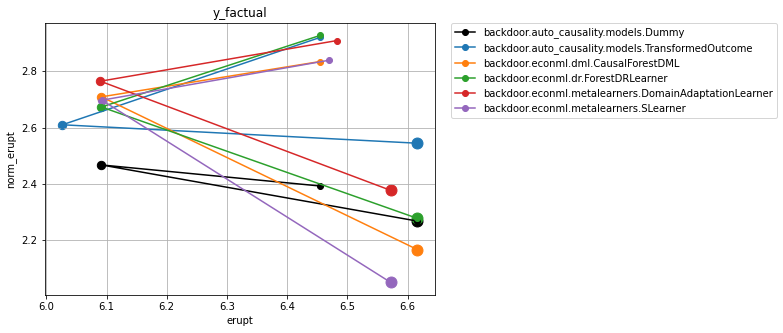

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])


plt.figure(figsize = (7,5))
plt.title(outcome)

m1 = "erupt"
m2 = "norm_erupt"

for (est, scr), col in zip(ac.scores.items(),colors):
    try:
        sc = [scr["scores"]['train'][m1], scr["scores"]['validation'][m1], scr["scores"]['test'][m1]]
        crv = [scr["scores"]['train'][m2], scr["scores"]['validation'][m2], scr["scores"]['test'][m2]]
        plt.plot(sc, crv, color=col, marker="o", label=est)
        plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
        plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

    except:
        pass
plt.xlabel(m1)
plt.ylabel(m2)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.grid()
plt.show()


In [20]:
scr = ac.scores[ac.best_estimator]
intrp = scr["scores"]['validation']['intrp']
plt.figure(figsize=(15, 7))
intrp.plot(feature_names=intrp.feature_names, fontsize=10)
plt.title(f"{ac.best_estimator}_{outcome}")
plt.show()


ImportError: matplotlib is no longer a dependency of the main econml package; install econml[plt] or econml[all] to require it, or install matplotlib separately, to use the tree interpreters

<Figure size 1080x504 with 0 Axes>

In [ ]:
# TODO: add SHAP plots!
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)


scr = ac.scores[ac.best_estimator]
print(outcome, ac.best_estimator)
est = ac.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ac.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
plt.show()


In [ ]:
from auto_causality.scoring import  group_ate
# plot out-of sample difference of outcomes between treated and untreated for the points where a model predicts positive vs negative impact
my_est = ac.best_estimator
stats = []

v = ac.scores[my_est]['scores']['test']['values']

sts = group_ate(v['treated'], v[outcome], v['norm_policy'])

display(sts)


colors = (matplotlib.colors.CSS4_COLORS['black'],
    matplotlib.colors.CSS4_COLORS['red'],
    matplotlib.colors.CSS4_COLORS['blue'])

grp = sts["policy"].unique()

for i,(p,c) in enumerate(zip(grp, colors)):
    st = sts[sts["policy"] == p]
    plt.errorbar(np.array(range(len(st))) +0.1*i, st["mean"].values[0],  yerr = st["std"].values[0], color=c)
plt.legend(grp)
plt.grid(True)
plt.title(my_est.split('.')[-1])
plt.show()